In [83]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## 1

Get data as tensors.

In [84]:
full_X_train, full_y_train = np.load('X_train.npy'), np.load('y_train.npy')
X_test, y_test = np.load('X_test.npy'), np.load('y_test.npy')

full_X_train.shape, full_y_train.shape, X_test.shape, y_test.shape

((467, 30), (467,), (117, 30), (117,))

In [85]:
train_size = int(len(full_X_train) * 0.75)
X_train, y_train = full_X_train[:train_size], full_y_train[:train_size]
X_dev, y_dev = full_X_train[train_size:], full_y_train[train_size:]

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((350, 30), (350,), (117, 30), (117,))

In [86]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32) 
X_dev, y_dev = torch.tensor(X_dev, dtype=torch.float32), torch.tensor(y_dev, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [87]:
X_train.shape, y_train.shape

(torch.Size([350, 30]), torch.Size([350]))

In [88]:
X_dev.shape, y_dev.shape

(torch.Size([117, 30]), torch.Size([117]))

In [89]:
X_test.shape, y_test.shape

(torch.Size([117, 30]), torch.Size([117]))

## 2 

Define our model.

In [90]:
class simple_mlp(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l0 = nn.Linear(30, 500)
        self.l1 = nn.Linear(500, 500)
        self.l2 = nn.Linear(500, 500)
        self.l3 = nn.Linear(500, 500)
        self.out = nn.Linear(500, 1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.l0(x))
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))

        out = self.out(x)

        return out

In [91]:
# quick sanity check
torch.arange(0, 30, dtype=torch.float32).dtype

torch.float32

In [92]:
model = simple_mlp()

model(torch.arange(0, 30, dtype=torch.float32))

tensor([-0.3644], grad_fn=<ViewBackward0>)

# 3

Define a loss function.

In [93]:
criterion = nn.BCEWithLogitsLoss()

## 4

Define a optimzer.

In [94]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 

## 5 

Define training loop.

1. clear optimizer
2. forward pass
3. compute loss
4. propigate loss
5. optim step


In [95]:
optimizer.zero_grad()
pred = model(X_train)
loss = criterion(pred, y_train.unsqueeze(dim=1))
loss.backward()
optimizer.step()
loss.item()

0.6934633255004883

## 6

Thats no way to train NN. Lets add some things to help us:
1. Vizualize loss curve.

2. Add a `for loop`.

3. Use Dev set.

In [96]:
lossi = []
devlossi = []

100%|██████████| 40/40 [00:00<00:00, 145.64it/s]


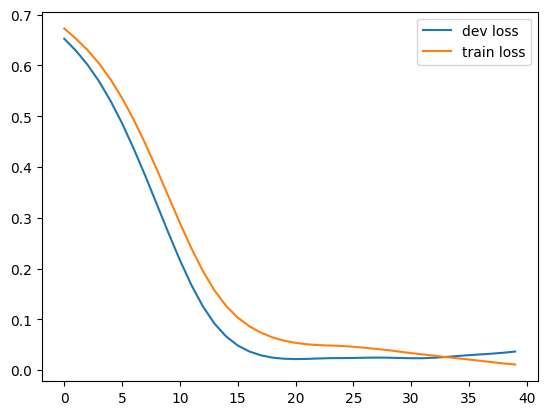

In [97]:
for epoch in tqdm(range(40)):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, y_train.unsqueeze(dim=1))
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

    model.eval()
    with torch.no_grad():
        dev_pred = model(X_dev)
        dev_loss = criterion(dev_pred, y_dev.unsqueeze(dim=1))

        devlossi.append(dev_loss.item())



plt.plot(devlossi, label='dev loss')
plt.plot(lossi, label='train loss')
plt.legend()
plt.show()

In [98]:
#LETS TEST

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95        51
         1.0       0.94      0.98      0.96        66

    accuracy                           0.96       117
   macro avg       0.96      0.95      0.96       117
weighted avg       0.96      0.96      0.96       117



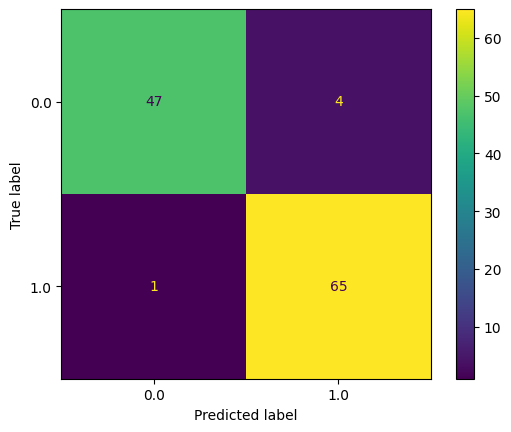

In [99]:
model.eval()
test_pred = model(X_test)


test_pred = test_pred.detach().numpy()
binary_pred = (test_pred > 0.5).astype(int)
print(classification_report(y_test, binary_pred))
ConfusionMatrixDisplay.from_predictions(y_test, binary_pred);

This is not that good lets see what we can do to get better results

## 8

Extra stuff.
- mini batches
- dropout
- batchnorm

**8.1** 

Redefine the model.

In [106]:
class improved_mlp(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.l0 = nn.Linear(30, 500)

        self.l1 = nn.Linear(500, 500)
        # self.bn1 = nn.BatchNorm1d(500)

        self.l2 = nn.Linear(500, 500)
        # self.bn2 = nn.BatchNorm1d(500)

        self.l3 = nn.Linear(500, 500)
        # self.bn3 = nn.BatchNorm1d(500)

        self.out = nn.Linear(500, 1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.l0(x))
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        out = self.out(x)

        return out

In [123]:
model_imporoved = improved_mlp()
criterion = nn.BCEWithLogitsLoss()

## EXAMPLE OF CODE THAT WILL RUN BUT I WRONG !!!!!!!!!
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 
optimizer = torch.optim.Adam(model_imporoved.parameters(), lr=0.0003) 


In [124]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128)

In [125]:
lossi = []
devlossi = []

100%|██████████| 15/15 [00:00<00:00, 81.48it/s]


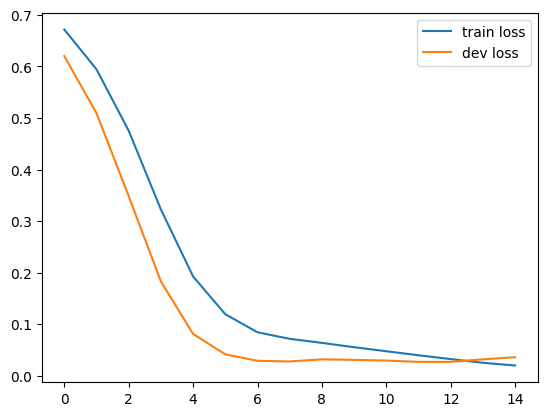

In [126]:
## EXAMPLE OF CODE THAT WILL RUN BUT I WRONG !!!!!!!!!
for epoch in tqdm(range(15)):
    
    loss_total = 0
    model_imporoved.train()
    for X_bacth, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model_imporoved(X_bacth)
        loss = criterion(pred, y_batch.unsqueeze(dim=1))
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total/len(train_loader))
    

    model_imporoved.eval()
    with torch.no_grad():
        dev_pred = model_imporoved(X_dev)
        dev_loss = criterion(dev_pred, y_dev.unsqueeze(dim=1))

        devlossi.append(dev_loss.item())




plt.plot(lossi, label='train loss')
plt.plot(devlossi, label='dev loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        51
         1.0       0.96      0.98      0.97        66

    accuracy                           0.97       117
   macro avg       0.97      0.96      0.97       117
weighted avg       0.97      0.97      0.97       117



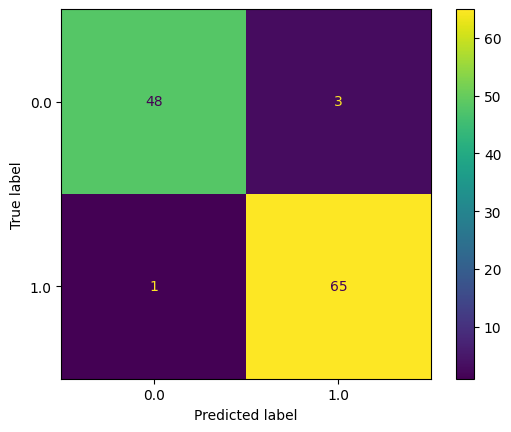

In [127]:
model_imporoved.eval()
test_pred = model_imporoved(X_test)


test_pred = test_pred.detach().numpy()
binary_pred = (test_pred > 0.5).astype(int)
print(classification_report(y_test, binary_pred))
ConfusionMatrixDisplay.from_predictions(y_test, binary_pred);